In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [2]:
init_Seed()

No GPU!


In [3]:
class MLDataset(Dataset):
    """ Dataset for loading and preprocessing the MoviesLen dataset. """
    def __init__(self, path, mode='train', target_only=False):
        super().__init__()
        self.mode = mode

        # Read data into numpy arrays
        data = np.loadtxt(path, dtype='long')

        # Convert data into PyTorch tensors
        self.data = torch.LongTensor(data[:, :2])
        self.target = torch.FloatTensor(data[:, 2])

        print(f'Max user: {max(self.data[:, 0])}')
        print(f'Max item: {max(self.data[:, 1])}')

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of MoviesLen Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [4]:
class MF(nn.Module):
    def __init__(self, n_users=1050, m_items=2001, n_factors=20):
        super(MF, self).__init__()

        self.U = torch.nn.Parameter(torch.rand(n_users, n_factors, requires_grad=True))

        self.P = torch.rand(m_items, 500 * n_factors, requires_grad=False)
        # self.Q = torch.nn.Parameter(torch.rand(n_factors * 500, n_factors, requires_grad=True))

        
        self.net = nn.Sequential(nn.Linear(500 * n_factors, n_factors), nn.ReLU(), nn.Linear(n_factors, n_factors))


        self.U.data.uniform_(-0.005, 0.005)
        # self.Q.data.uniform_(-0.005, 0.005)
        # self.Q.weight.data.uniform_(-0.005, 0.005)
        
        self.criterion = nn.MSELoss(reduction='sum')
    
    def forward(self, user, item):
        # return torch.einsum('ij, ij -> i', [self.U[user], self.P[item] @ self.Q])
        return torch.einsum('ij, ij -> i', [self.U[user], self.net(self.P[item])])

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = MLDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Train/Dev/Test**

In [6]:
# U = torch.rand(size=(1005, 20), requires_grad=True)
# V = torch.rand(size=(2005, 20), requires_grad=True)
# with torch.no_grad():
#     U /= 100
#     V /= 100

## **Training**

In [7]:
# def model(X):
#     return torch.einsum('ij, ij -> i', [U[X[:, 0]], V[X[:, 1]]])

# def squared_loss(y_hat, y):  #@save
#     """Squared loss."""
#     return (y_hat - y.reshape(y_hat.shape))**2 / 2

# def objective(X, y):
#     return squared_loss(model(X), y).sum() + (U[X[:, 0]].norm() ** 2 + V[X[:, 1]].norm() ** 2) * 0.01

# def sgd(params, lr, batch_size):  #@save
#     """Minibatch stochastic gradient descent."""
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad
#             param.grad.zero_()

In [8]:
def train(tr_set, dv_set, model, config):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_size = config['batch_size']

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])
            mse_loss = model.cal_loss(y_hat, y)
            mse_loss.backward()
            
            optimizer.step()
            # scheduler.step()

            # loss_record['train'].append(mse_loss.detach().cpu().item())
            loss_record['train'].append(mse_loss.detach().cpu().item() / len(y))

            # print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item()))
            print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item() / len(y)))

        
        epoch += 1
        
        # print("train_loss: {:.4f}".format(np.mean(loss_record['train'][-100:])))

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            early_stop_cnt = 0
            print("Saving model (epoch = {:4d}  loss = {:.4f} )".format(epoch, dev_mse))
            torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        
        # if epoch > 10:
        #     break
        
        loss_record['dev'].append(dev_mse)

        if early_stop_cnt > config['early_stop']:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

## **Validation**

In [9]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for X, y in dv_set:                         # iterate through the dataloader
        X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        # total_loss += mse_loss.detach().cpu().item() * len(y)    # accumulate loss
        total_loss += mse_loss.detach().cpu().item()     # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [11]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False               

config = {
    'n_epochs': 500,              # maximum number of epochs
    'batch_size': 5000,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.002,                # learning rate
        # 'weight_decay': 0.001
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 3,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    'D': 20
}

# **Load data and model**

In [12]:
ML100K_train = '../data/ML100K/ML100K_copy1_train.txt'
ML100K_test = '../data/ML100K/ML100K_copy1_test.txt'

ML1M_train = '../data/ML1M/ML1M_copy1_train.txt'
ML1M_test = '../data/ML1M/ML1M_copy1_test.txt'

tr_set = prep_dataloader(ML100K_train, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(ML100K_test, 'dev', config['batch_size'], target_only=target_only)
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

Max user: 943
Max item: 1682
Finished reading the train set of MoviesLen Dataset (60000 samples found, each dim = 2)
Max user: 943
Max item: 1679
Finished reading the dev set of MoviesLen Dataset (20000 samples found, each dim = 2)


In [13]:
model = MF(n_factors=config['D']).to(device) 

# **Start Training!**

In [14]:
model.P[[4, 5]]

tensor([[0.3922, 0.7650, 0.2115,  ..., 0.4937, 0.1280, 0.9186],
        [0.2747, 0.6171, 0.3101,  ..., 0.4746, 0.1673, 0.0543]])

In [15]:
%%time
for _ in range(3):
    model_loss, model_loss_record = train(tr_set, dv_set, model, config)
    model.P = model.net(model.P).detach()
    model.net = nn.Sequential(nn.Linear(config['D'], config['D']), nn.ReLU(), nn.Linear(config['D'], config['D']))
    print("ending a era !!!")

# model_loss, model_loss_record = train(tr_set, dv_set, model, config)

train_loss: 13.8189
train_loss: 14.1947
train_loss: 9.1626
train_loss: 3.3587
train_loss: 2.6416
train_loss: 4.8156
train_loss: 2.4126
train_loss: 1.3548
train_loss: 2.1425
train_loss: 2.8098
train_loss: 2.8440
train_loss: 2.2433
Saving model (epoch =    1  loss = 1.5406 )
train_loss: 1.4893
train_loss: 1.3619
train_loss: 1.8755
train_loss: 2.0197
train_loss: 1.5817
train_loss: 1.2131
train_loss: 1.3275
train_loss: 1.5460
train_loss: 1.7609
train_loss: 1.6302
train_loss: 1.4026
train_loss: 1.2541
Saving model (epoch =    2  loss = 1.3134 )
train_loss: 1.2501
train_loss: 1.4119
train_loss: 1.4104
train_loss: 1.2007
train_loss: 1.1635
train_loss: 1.2075
train_loss: 1.2621
train_loss: 1.3493
train_loss: 1.2833
train_loss: 1.1503
train_loss: 1.1845
train_loss: 1.2595
Saving model (epoch =    3  loss = 1.2296 )
train_loss: 1.2075
train_loss: 1.1428
train_loss: 1.0977
train_loss: 1.1147
train_loss: 1.1837
train_loss: 1.1927
train_loss: 1.1915
train_loss: 1.1417
train_loss: 1.1387
train_loss:

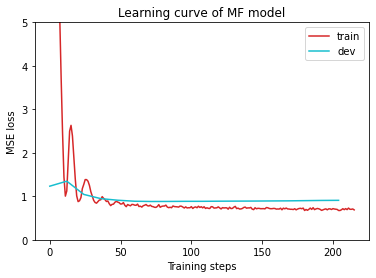

In [16]:
plot_learning_curve(model_loss_record, title='MF model')

In [17]:
model.P[[4, 5]]

tensor([[ 2.0617,  1.7238, -0.3759, -0.1983,  0.4020,  2.6015, -0.1356, -0.1985,
         -3.5833, -3.0285, -0.9899,  1.1028,  1.2840, -3.3871,  1.5687, -3.1156,
         -0.1765,  3.6538,  4.4763, -0.2468, -2.3748,  3.0666,  0.5724, -3.4215,
          1.5248, -1.8455,  3.9105,  4.2110, -2.3598, -0.7713, -2.6983,  1.9953,
         -0.3507,  2.8080, -1.4319,  0.2001, -1.9078, -0.1570,  0.2969, -1.5796,
         -2.7680, -4.1318,  3.9473, -2.2000,  0.3806,  0.2129,  0.8516,  1.7521,
         -0.4792,  0.9839],
        [ 1.7214,  1.2017, -0.9186, -1.7822,  0.2922,  2.3748, -0.5615,  1.3395,
         -2.3136, -2.0062,  1.1644,  1.9431,  0.7171, -3.8528,  2.5209, -2.5763,
         -1.2201,  3.2894,  3.9983, -0.0953, -1.7453,  2.6108,  0.9733, -2.4009,
          1.2874, -1.9689,  3.9598,  4.1865, -2.3875, -1.4626, -1.8824,  2.1808,
         -1.1806,  2.0207, -1.3982,  0.9864, -0.6035,  1.2516, -0.4655, -1.9595,
         -3.2077, -3.0446,  3.0443, -1.5433,  0.8460,  0.9814,  1.0091, -0.3905,


In [18]:
np.sqrt(model_loss)

0.9385431956378593

In [19]:
np.sqrt(model_loss_record['dev'][-1])

0.9526562628136788

In [20]:
# del model
# model = MF().to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# dev(dv_set, model, device)

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [21]:
# def save_pred(preds, file):
#     ''' Save predictions to specified file '''
#     print('Saving results to {}'.format(file))
#     with open(file, 'w') as fp:
#         writer = csv.writer(fp)
#         writer.writerow(['id', 'tested_positive'])
#         for i, p in enumerate(preds):
#             writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)


In [22]:
pp = torch.nn.Parameter(torch.rand(2, 3, requires_grad=True))
pp

Parameter containing:
tensor([[0.7284, 0.8145, 0.1988],
        [0.5821, 0.2494, 0.4575]], requires_grad=True)

In [23]:
pp[0]

tensor([0.7284, 0.8145, 0.1988], grad_fn=<SelectBackward>)

In [24]:
for X, y in dv_set:                         # iterate through the dataloader
    X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
        print(((pred -y) ** 2).mean())

# total_loss = total_loss / len(dv_set.dataset)   
    

tensor(14.2173)
tensor(13.6264)
tensor(13.4860)
tensor(14.2117)


In [25]:
# U = torch.nn.Parameter(torch.rand(2, 3, requires_grad=True))
# P = torch.nn.Parameter(torch.rand(2, 6, requires_grad=False))
# net = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
# torch.einsum('ij, ij -> i', [U[[0, 1]], net(P[[0, 1]])])
# gg = torch.Tensor([0.3, 0.7])
# nn.Sigmoid()(gg)